## **0.0 Imports**

In [70]:
import re
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import cm

from scipy.cluster import hierarchy as hc

from sklearn import preprocessing as pp
from sklearn import cluster       as c
from sklearn import metrics       as m
from sklearn import decomposition as dd
from sklearn import ensemble      as en
from sklearn import preprocessing as pp
from sklearn import mixture       as mx
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

from pandas_profiling import ProfileReport
from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import umap.umap_ as umap

plt.rcParams['figure.figsize'] = [24, 9]

### 0.1 Helper Functions

### 0.2 Load Dataset

In [2]:
# laod dataset
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding = 'unicode_escape')

# drop extra column
df_raw = df_raw.drop(columns = ['Unnamed: 8'], axis=1)

In [3]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

## **1.0 Descrição dos dados**

In [4]:
df1 = df_raw.copy()

### **1.1 Rename columns**

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns  = cols_new

### **1.2 Data dimensions**

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


### **1.3 Data types**

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [8]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


### **1.4 Check NA**

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### **1.5 Replace NA**

In [10]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [11]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

# merge with original dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalese
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x','customer_id_y'], axis=1)

In [12]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

### **1.6 Changes dTypes**

In [13]:
#customer id
df1['customer_id'] = df1['customer_id'].astype(int)

In [14]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

### **1.7 Descriptive Statistics**

In [16]:
num_attributes = df1.select_dtypes(include=['float64', 'int64'])
cat_attributes = df1.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]'])

#### **1.7.1 Numerical Attributes**

In [17]:
# central tendency - mean, median
c1 = pd.DataFrame(num_attributes.apply(np.mean)).T
c2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - min, max, range, standard deviation, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.min)).T
d2 = pd.DataFrame(num_attributes.apply(np.max)).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.mean())).T
d4 = pd.DataFrame(num_attributes.apply(np.std)).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([c1, c2, d4, d1, d2, d3, d5, d6]).T.reset_index()
m.columns = ['attributes', 'mean', 'median', 'std', 'min','max','range','skew','kurtosis']
m

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,quantity,9.552250,3.00,218.080957,-80995.00,80995.0,80985.447750,-0.264076,119769.160031
1,unit_price,4.611114,2.08,96.759764,-11062.06,38970.0,38965.388886,186.506972,59005.719097
2,customer_id,16688.840453,16249.00,2911.408666,12346.00,22709.0,6020.159547,0.487449,-0.804287


##### **1.7.1.1 <font color='red'> Numerical Attributes - Investigating** </font>

1. Quantidade negativa (pode ser devolução?)
2. Preço unitário igual a zero (pode ser promoção?)

#### **1.7.2 Categorical Attributes**

In [18]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


##### **Invoice no**

In [19]:
# invoice number with letter
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :].drop_duplicates()
df_letter_invoices.head()

print('Total number of invoices:{}'.format(len(df_letter_invoices)))
print('total number of negative quantity:{}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))

Total number of invoices:9254
total number of negative quantity:9251


##### **Stock code**

In [20]:
# stock code with letter
len_stockCode_letter = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates().count()
df_onlyLetter_stockCode = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()
print('Total number of stock code:{}'.format(len_stockCode_letter))
print('Types stock code with only letter:{}'.format(df_onlyLetter_stockCode))

Total number of stock code:1124
Types stock code with only letter:['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK']


##### **Description**

##### **Country**

In [21]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [22]:
df1['country'].value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [23]:
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


## **2.0 Filtragem de Variáveis**

In [24]:
df2 = df1.copy()

In [25]:
df2.loc[df2['quantity'] < 0, :].sort_values(['customer_id', 'description']).head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2017-01-16,1.04,United Kingdom,12346
129743,C547388,21914,BLUE HARMONICA IN BOX,-12,2017-03-20,1.25,Norway,12352
129738,C547388,37448,CERAMIC CAKE DESIGN SPOTTED MUG,-12,2017-03-20,1.49,Norway,12352
129741,C547388,22645,CERAMIC HEART FAIRY CAKE MONEY BANK,-12,2017-03-20,1.45,Norway,12352
129739,C547388,22784,LANTERN CREAM GAZEBO,-3,2017-03-20,4.95,Norway,12352
129742,C547388,22413,METAL SIGN TAKE IT OR LEAVE IT,-6,2017-03-20,2.95,Norway,12352
106394,C545329,M,Manual,-1,2017-02-27,280.05,Norway,12352
106395,C545329,M,Manual,-1,2017-02-27,183.75,Norway,12352
106397,C545330,M,Manual,-1,2017-02-27,376.50,Norway,12352
129740,C547388,22701,PINK DOG BOWL,-6,2017-03-20,2.95,Norway,12352


In [26]:
#df1.loc[df1['unit_price'] > 0.03, ['customer_id','description','unit_price']].sort_values('unit_price', ascending=True).head(10)

In [27]:
# ======= Numerical Attributes =======
# unit price
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# ======= Categorical Attributes =======
# Stock code
df2 = df2[~df2['stock_code'].isin(['POST','D','M','DOT','CRUK', 'PADS'])]

# Description
df2 = df2.drop(columns='description', axis=1)

#country
df2 = df2[~df2['country'].isin(['Unspecified','European Community'])]

# bad users
df2 = df2[~df2['customer_id'].isin(['16446'])]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] > 0, :]

In [28]:
df2_returns.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
154,C536383,35004C,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,-24,2016-11-29,0.29,United Kingdom,17548
238,C536391,21980,-24,2016-11-29,0.29,United Kingdom,17548


In [29]:
df2_purchases.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


## **3.0 Feature Engineering**

In [30]:
df3 = df2.copy()

### **3.1 Feature Creation**

In [31]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


#### **3.1.1 Gross Revenue**

In [32]:
# Gross Revenue (Faturamento) quantity * price
df2_purchases.loc[:,'gross_revenue'] = df2_purchases.loc[:,'quantity'] * df2_purchases.loc[:,'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

/tmp/ipykernel_4070/4180608733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:,'gross_revenue'] = df2_purchases.loc[:,'quantity'] * df2_purchases.loc[:,'unit_price']


customer_id        0
gross_revenue    140
dtype: int64

#### **3.1.2 Recency - Days at last purchase**

In [33]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:,['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue    140
recency_days     140
dtype: int64

#### **3.1.3 Quantity of purchase**

In [34]:
# total quantity of purchase
df_qtd = df2_purchases.loc[:,['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'qtde_invoices'})
df_ref = pd.merge(df_ref, df_qtd, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue    140
recency_days     140
qtde_invoices    140
dtype: int64

#### **3.1.4 Quantity of items purchased**

In [35]:
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum()
                                                            .reset_index()
                                                            .rename(columns={'quantity':'qtde_items'}))

df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue    140
recency_days     140
qtde_invoices    140
qtde_items       140
dtype: int64

#### **3.1.5 Quantity of products purchased**

In [36]:
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count()
                                                            .reset_index()
                                                            .rename(columns={'stock_code':'qtde_products'}))

df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue    140
recency_days     140
qtde_invoices    140
qtde_items       140
qtde_products    140
dtype: int64

#### **3.1.5 Avg Ticket Value**

In [37]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue    140
recency_days     140
qtde_invoices    140
qtde_items       140
qtde_products    140
avg_ticket       140
dtype: int64

#### **3.1.6 Avg Recency Days**

In [38]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[True, True] )
df_aux['previous_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['previous_customer_id'] else np.nan, axis=1 )
df_aux = df_aux.drop( ['invoice_date', 'previous_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()


customer_id            0
gross_revenue        140
recency_days         140
qtde_invoices        140
qtde_items           140
qtde_products        140
avg_ticket           140
avg_recency_days    2870
dtype: int64

#### **3.1.7 Frequency Purchase**

In [39]:
df_aux = (df2_purchases[['customer_id','invoice_no','invoice_date']].drop_duplicates()
                                                 .groupby('customer_id')
                                                 .agg(max_ = ('invoice_date', 'max'),
                                                      min_ = ('invoice_date', 'min'),
                                                      days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days ) + 1),
                                                      buy_ = ('invoice_no', 'count'))).reset_index()

# frequency
df_aux['frequency'] = df_aux[['days_','buy_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue        140
recency_days         140
qtde_invoices        140
qtde_items           140
qtde_products        140
avg_ticket           140
avg_recency_days    2870
frequency            140
dtype: int64

#### **3.1.7 Number of Returns**

In [40]:
df_returns = df2_returns.loc[:,['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue        140
recency_days         140
qtde_invoices        140
qtde_items           140
qtde_products        140
avg_ticket           140
avg_recency_days    2870
frequency            140
qtde_returns           0
dtype: int64

#### **3.1.8 Avg Basket Size - Quantidade itens por cesta**

In [41]:
df_aux = (df2_purchases.loc[:,['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                        .agg(n_purchase=('invoice_no', 'nunique'),
                                                                             n_products=('quantity', 'sum'))
                                                                        .reset_index())

df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id            0
gross_revenue        140
recency_days         140
qtde_invoices        140
qtde_items           140
qtde_products        140
avg_ticket           140
avg_recency_days    2870
frequency            140
qtde_returns           0
avg_basket_size      140
dtype: int64

#### **3.1.9 Unique Basket Size - Quantidade de produtos distintos por compra**

In [42]:
df_aux = (df2_purchases.loc[:,['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                          .agg(n_purchase=('invoice_no', 'nunique'),
                                                                               n_products=('stock_code', 'count'))
                                                                          .reset_index())

df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue              140
recency_days               140
qtde_invoices              140
qtde_items                 140
qtde_products              140
avg_ticket                 140
avg_recency_days          2870
frequency                  140
qtde_returns                 0
avg_basket_size            140
avg_unique_basket_size     140
dtype: int64

### **3.2 Dataframe atual**

In [43]:
df_ref

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,8.735294
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,19.000000
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,15.466667
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,5.600000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
5836,22706,5699.00,1.0,1.0,1747.0,634.0,8.988959,NaN,1.000000,0.0,1747.000000,634.000000
5837,22707,6756.06,0.0,1.0,2010.0,730.0,9.254877,NaN,1.000000,0.0,2010.000000,730.000000
5838,22708,3217.20,0.0,1.0,654.0,59.0,54.528814,NaN,1.000000,0.0,654.000000,59.000000
5839,22709,3950.72,0.0,1.0,731.0,217.0,18.206083,NaN,1.000000,0.0,731.000000,217.000000


## **4.0 EDA (Exploratory Data Analysis)**

In [87]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

In [45]:
df4.shape

(2969, 12)

In [46]:
df4.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,8.735294
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,19.000000
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,15.466667
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,5.600000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,1.000000


### **4.1 Univariate Analysis**

**Notes**
1. Clusters coesos e separados
2. Métricas
    - min, max, range (Dispersão)
    - média e mediana (Tendencia central)
    - Desvio padrão e Variância
    - Coeficiente de variação (desvio-padrao/media)
    - Distribuição

In [47]:
#profile = ProfileReport(df4)
#profile.to_file('output.html')

#### **4.1.1 Gross Revenue**

In [48]:
df4.sort_values('gross_revenue', ascending=False).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1025,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.203390,288.0,2733.944444,28.611111
500,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.163043,0.0,1068.733333,7.183333
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,12.821429,0.127778,952.0,1521.586957,7.326087
3364,16446,168472.50,0.0,2.0,80997.0,3.0,56157.500000,205.000000,0.009709,80995.0,40498.500000,1.500000
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,2.601399,0.533512,3332.0,403.331658,28.507538


In [49]:
df3[df3['customer_id'] == 14646].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646


In [50]:
np.sum(df3.loc[df3['customer_id']==14646, 'quantity'] * df3.loc[df3['customer_id']==14646, 'unit_price'])

278778.02

#### **4.1.2 Avg Ticket**

In [51]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
3364,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,205.0,0.009709,80995.0,40498.5,1.5


In [52]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,-80995,2017-12-07,2.08,United Kingdom,16446



Ticket Médio está contando com compras devolvidas

### **4.2 Bivariate Analysis**

In [53]:
cols = ['customer_id']
df42 = df4.drop(cols, axis=1)

In [54]:
# plt.figure(figsize=(25,12))
# sns.pairplot(df42)

**Notes**
1. Frequecy has low variance
2. Avg Ticket has low variance

### **4.3 Estudo dos Espaços**

In [88]:
#df43 = df4.drop(columns=['customer_id'], axis=1).copy()

cols_selected = ['customer_id','gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[cols_selected].copy()

In [89]:
mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mm.fit_transform(df43[['recency_days']])
#df43['qtde_invoices'] = mm.fit_transform(df43[['qtde_invoices']])
#df43['qtde_items'] = mm.fit_transform(df43[['qtde_items']])
df43['qtde_products'] = mm.fit_transform(df43[['qtde_products']])
#df43['avg_ticket'] = mm.fit_transform(df43[['avg_ticket']])
#df43['avg_recency_days'] = mm.fit_transform(df43[['avg_recency_days']])
df43['frequency'] = mm.fit_transform(df43[['frequency']])
df43['qtde_returns'] = mm.fit_transform(df43[['qtde_returns']])
#df43['avg_basket_size'] = mm.fit_transform(df43[['avg_basket_size']])
#df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])

X = df43.copy()

#### **4.3.1 PCA**

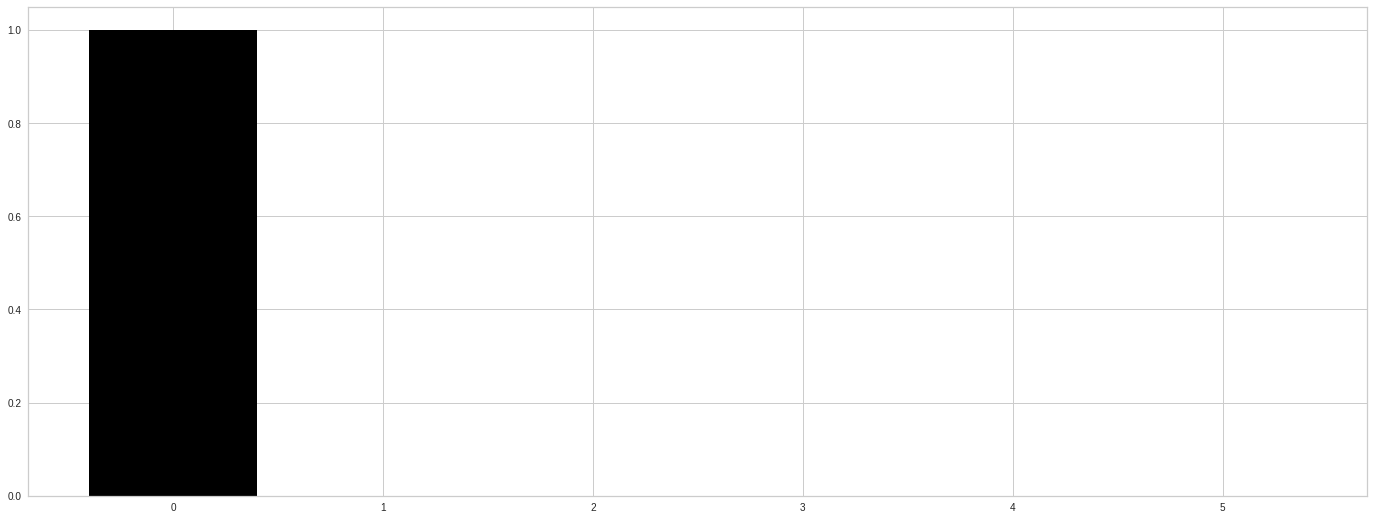

In [90]:
pca = dd.PCA(n_components = X.shape[1])

principal_componentes = pca.fit_transform(X)

#plot explained variable
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='Black')

# pca components
df_pca = pd.DataFrame(principal_componentes)

<AxesSubplot:xlabel='0', ylabel='1'>

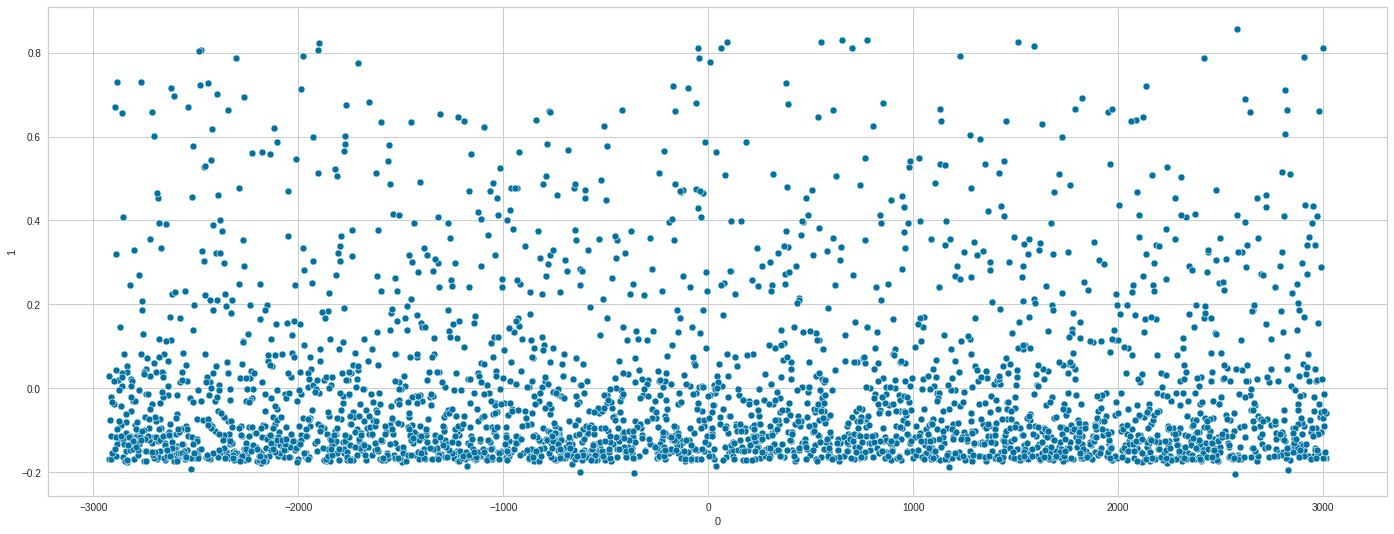

In [91]:
sns.scatterplot(x=0, y=1, data=df_pca)

#### **4.3.2 UMAP**

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

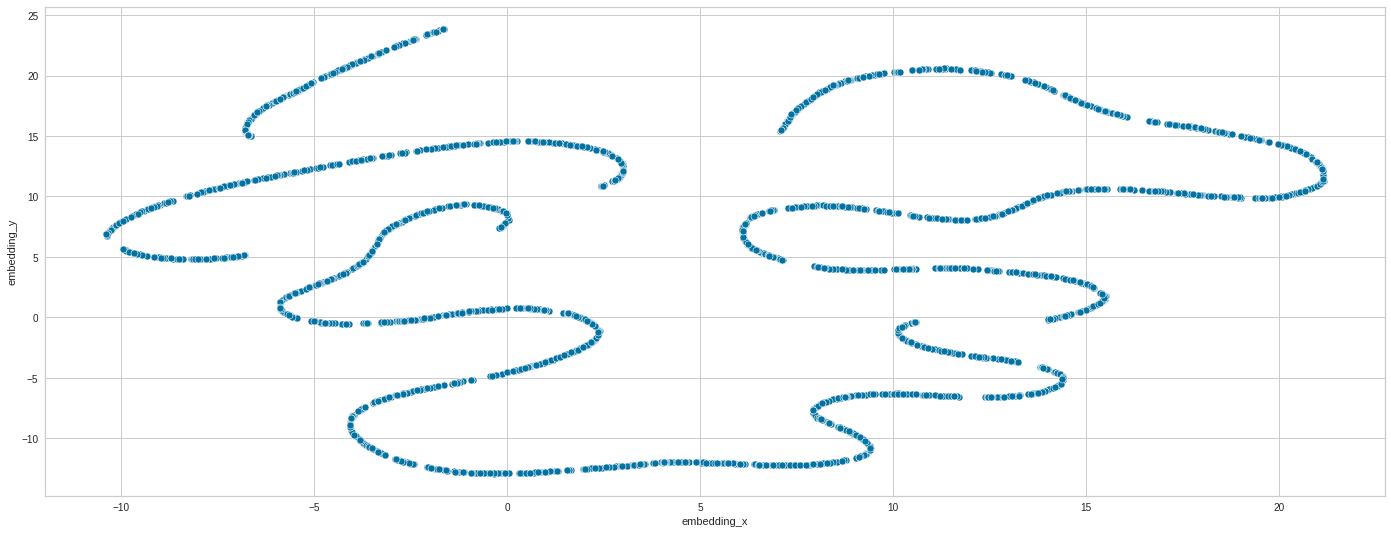

In [92]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

#### **4.3.3 t-SNE**

/home/romulo/Documentos/PA005/insiders-clustering-venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/romulo/Documentos/PA005/insiders-clustering-venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

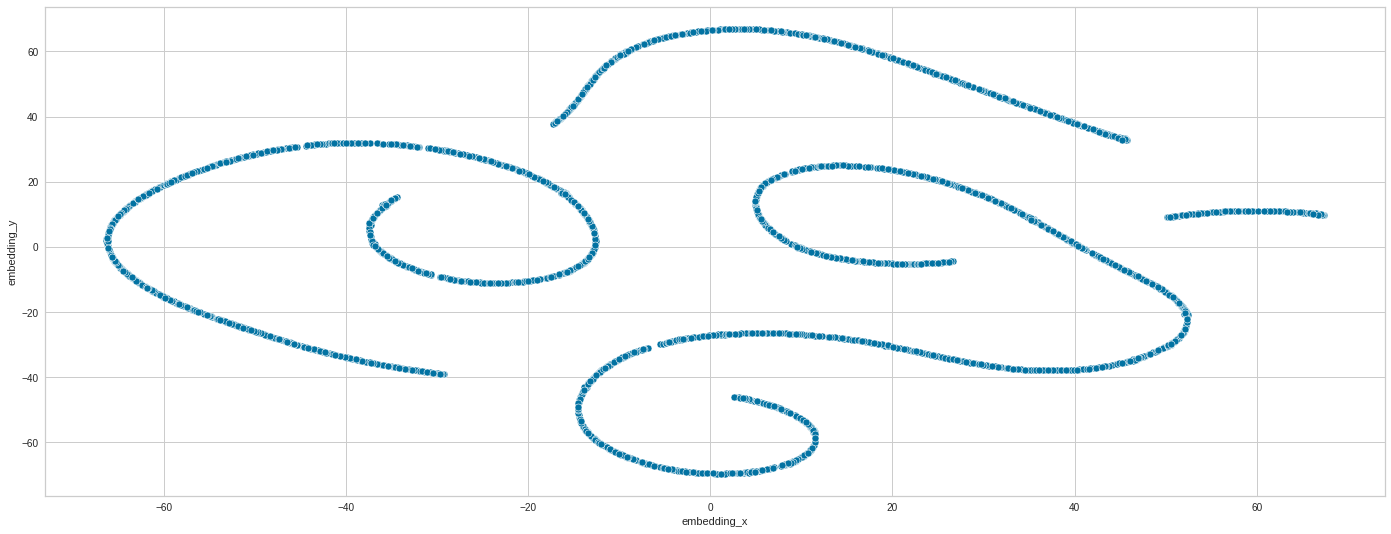

In [93]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot t-SNE
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

#### **4.3.4 Tree-Based Embedding**

In [94]:
# training dataset
X = df43.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

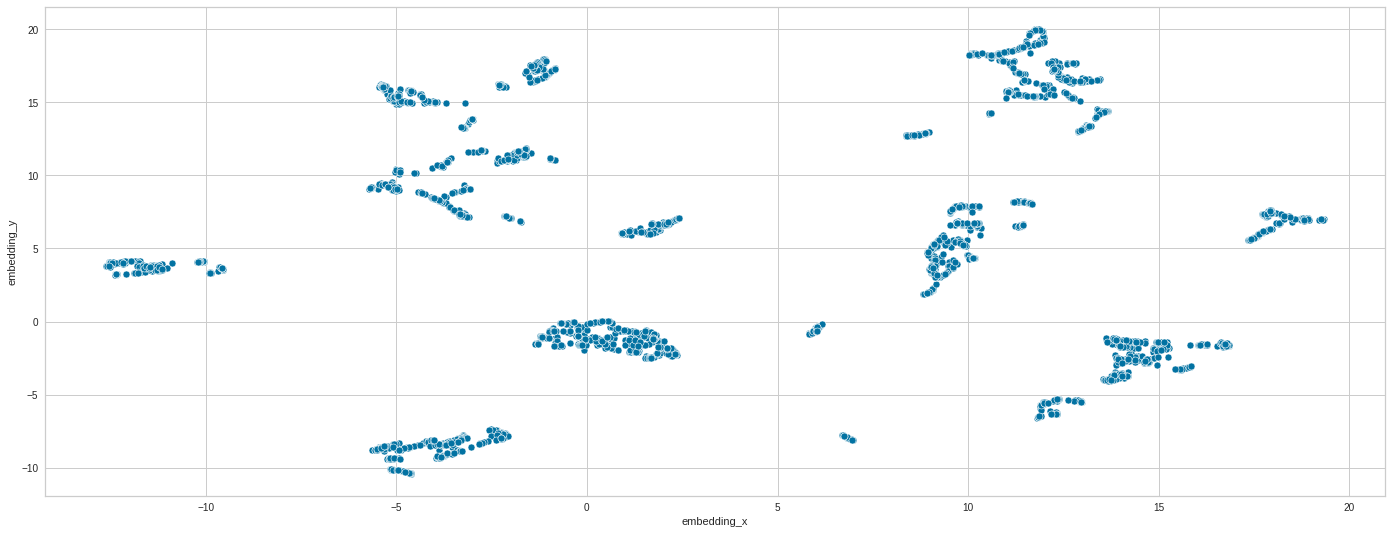

In [95]:
reducer = umap.UMAP(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(df_leaf)

#embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#plot t-SNE
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree)

## **5.0 Data Preparation**

Padronização (Standardization) -> Premissa que os dados vieram de uma distribuição normal  
Rescala (Rescale) -> Não premissa que os dados vieram de uma distribuição normal

**Regra do Coração**
1. Distribuição normal e não possui outlier --> Standard Scaler -  Média e Desvio Padrão
2. Distribuição normal e possui outlier --> Robust Scaler - Quartis
3. Não distribuição normal --> Min Max Scaler

**Teste de Normalidade**  
QQ Plot - Quantile Quantile Plot (Quatile Teórica x Quantile Real)  
KS Teste - Kolmogorov Smirnoff (Teste de Hipótese) Se o p-value > 0.5 -> Distribuição normal, p-value < 0.5 -> Não distribuição normal  

**Detecção de Outlier**  
Box Plot - Pontos são identificados como outlier
IRQ * 2.5 - Acima desse valor é outlier

3 < Z-Score < -3 Outlier

In [63]:
df5 = df_tree.copy()

In [64]:
df5.columns

Index(['embedding_x', 'embedding_y'], dtype='object')

## **6.0 Feature Selection**

In [65]:
df6 = df_tree.copy()

## **7.0 Hyperparameter Fine Tuning - Sobre o espaço de Embeddings** 

In [96]:
# X = df6.drop(columns=['customer_id'])
X = df_tree.copy()

In [97]:
#clusters = [2, 3, 4, 5, 6, 7]

clusters = np.arange(2, 25, 1)

In [98]:
X.head()

,embedding_x,embedding_y
0,11.489135,16.525164
1,18.761673,7.048147
2,11.210439,15.574699
3,-11.780272,4.128515
4,-4.441093,8.889080


### **7.1 K-Means**

In [99]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

Text(0.5, 1.0, 'Silhouette Score x K')

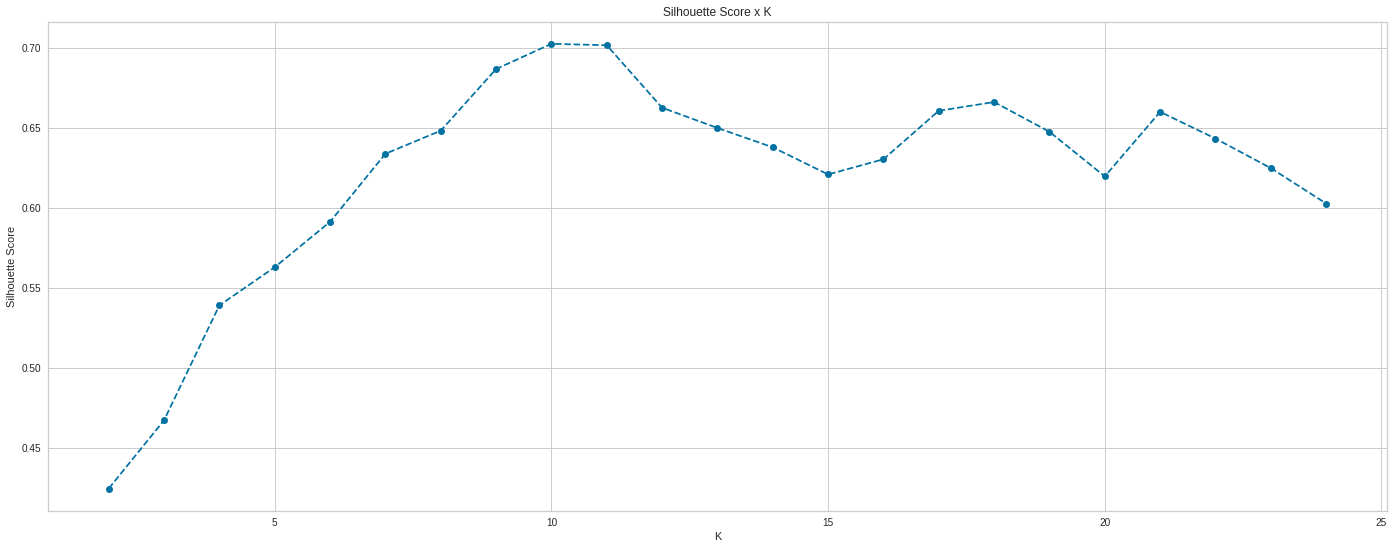

In [100]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K')

### **7.2 GMM**

In [101]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

Text(0.5, 1.0, 'Silhouette Score x K')

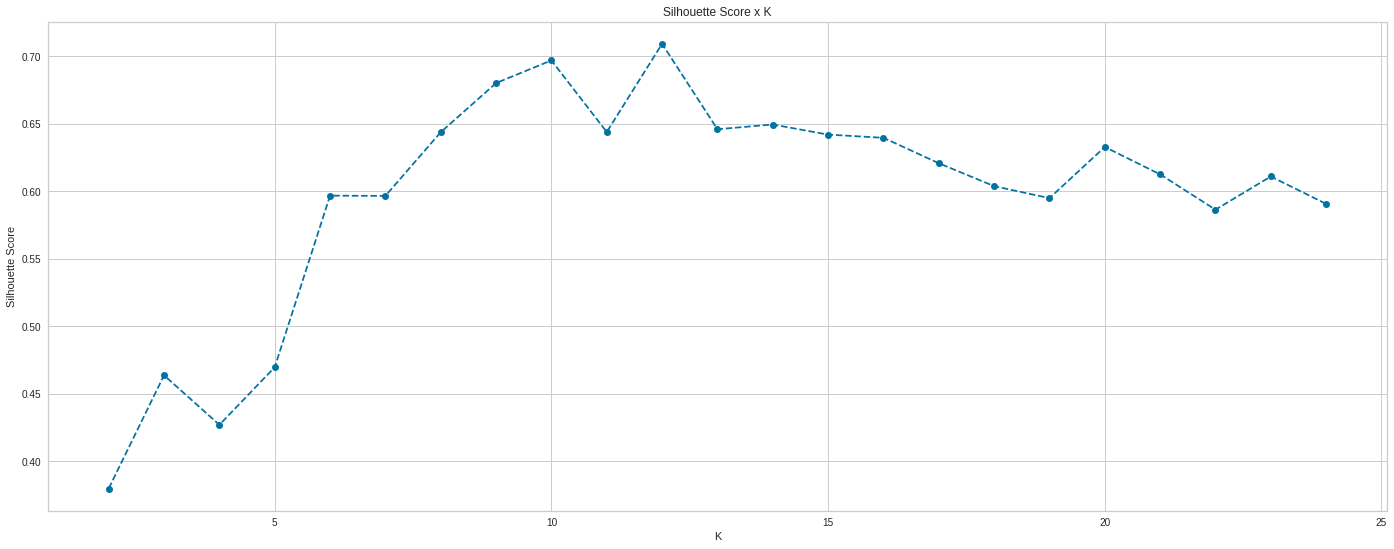

In [102]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K')

### **7.3 Hierarchical Clustering**

In [103]:
# model definition and training
hc_model = hc.linkage(X, 'ward')

[]

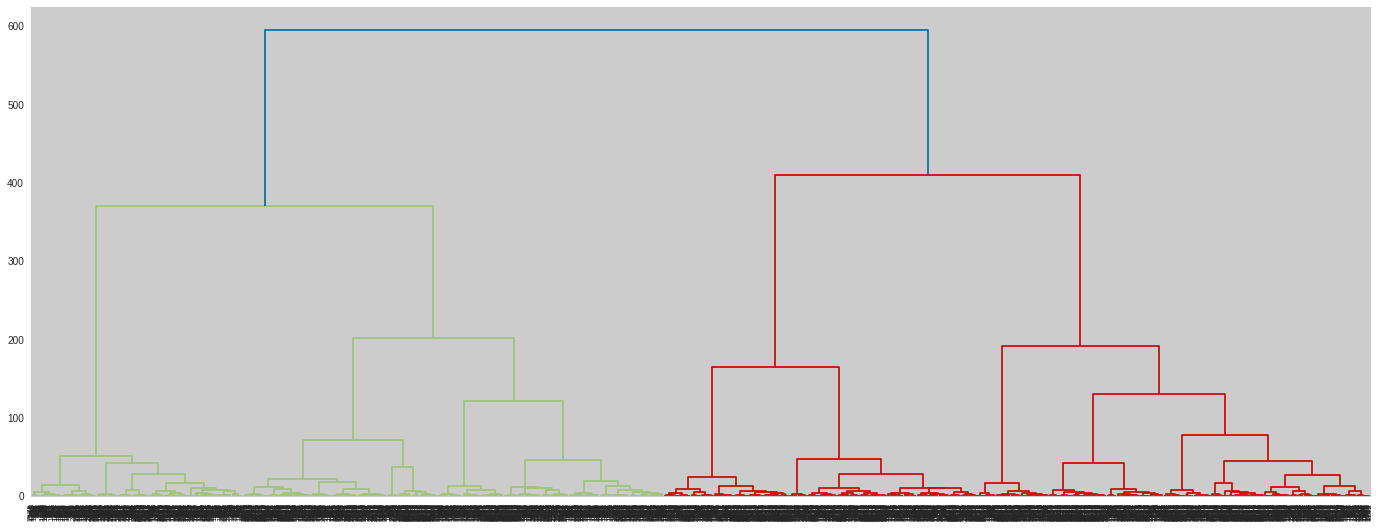

In [104]:
hc.dendrogram(
    hc_model,
    leaf_rotation=90,
    leaf_font_size=8
)

plt.plot()

[]

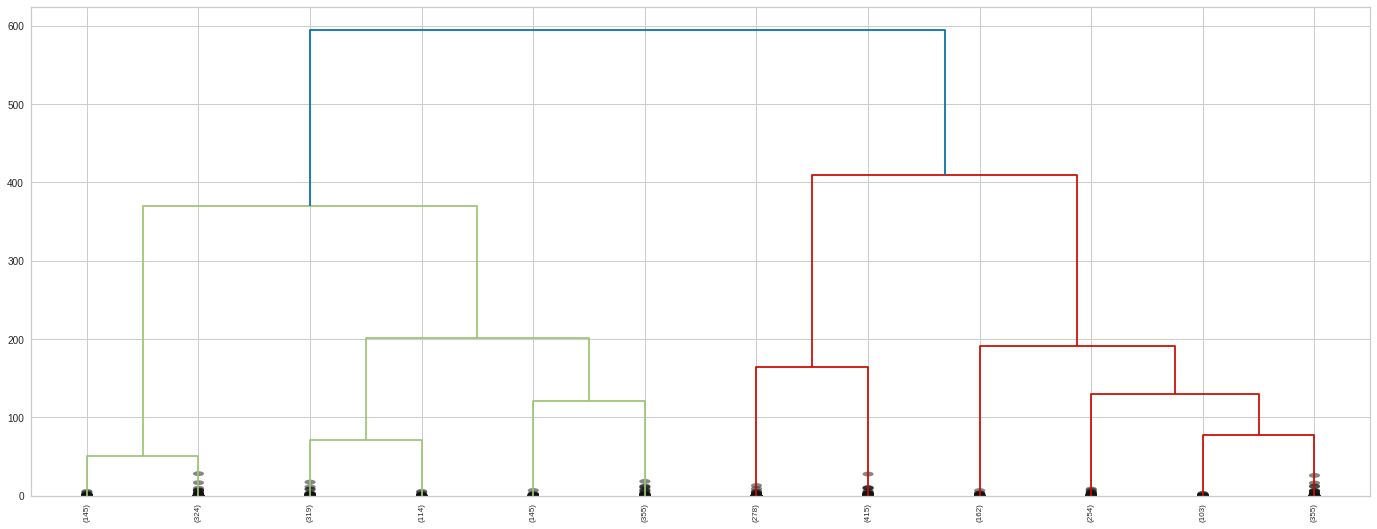

In [105]:
hc.dendrogram(
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.plot()

#### **7.3.1 HClustering Silhouette Score**

In [106]:
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

Text(0.5, 1.0, 'Silhouette Score x K')

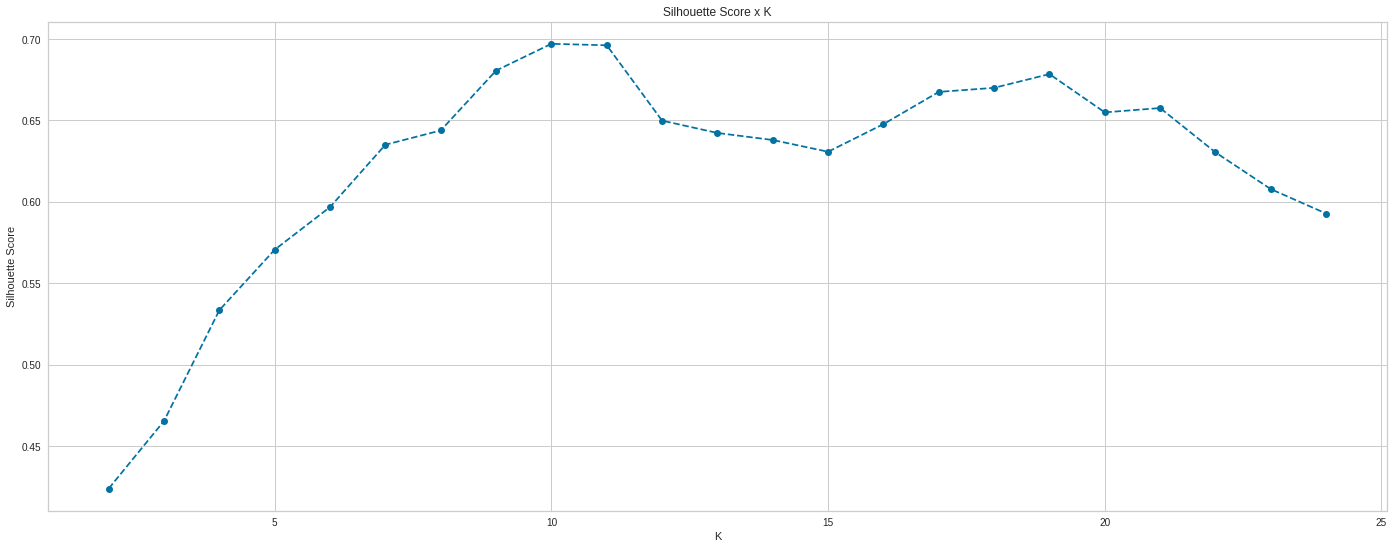

In [107]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K')

### **7.4 DBSCAN**

In [ ]:
# eps=2
# min_samples=20

# # model definition
# dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# # model training and predict
# labels = dbscan_model.fit_predict(X)


# sil = m.silhouette_score(X, labels, metric='euclidean')
# print('Sil: {}'.format(sil))
# print('Clusters: ', pd.unique(labels))

In [ ]:
# neighbors = NearestNeighbors(n_neighbors=20).fit(X)
# distance, indices = neighbors.kneighbors(X)

In [ ]:
# distance = np.sort(distance, axis=0)
# distance = distance[:,1]
# plt.plot(distance)

In [ ]:
# plt.plot(distance[2000:])

### **7.5 Results**

In [108]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list
    }
).T

df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.424409,0.467066,0.538879,0.562707,0.591068,0.633593,0.648009,0.686532,0.702313,0.701396,0.662386,0.649720,0.637625,0.620682,0.630160,0.660469,0.665912,0.647347,0.619465,0.659797,0.643106,0.624626,0.602524
GMM,0.379759,0.463671,0.426975,0.469641,0.596769,0.596584,0.643777,0.680174,0.696971,0.643908,0.709267,0.645978,0.649477,0.641984,0.639620,0.620793,0.603799,0.594920,0.632830,0.612521,0.586390,0.610970,0.590628
HC,0.423972,0.465463,0.533497,0.570586,0.596769,0.635026,0.643777,0.680537,0.696971,0.696054,0.649815,0.642240,0.637923,0.630712,0.647658,0.667445,0.669944,0.678372,0.654883,0.657546,0.630337,0.607767,0.592786


## **8.0 Model Training**

### **8.1 Models**

#### **8.1.1 GMM**

In [116]:
k = 8
# model definition
gmm_model = mx.GaussianMixture(n_components=k)

# model training
gmm_model.fit(X)

# model predict
labels = gmm_model.predict(X)

## **9.0 Cluster Analysis**

In [117]:
df9 = X.copy()
df9['cluster'] = labels

In [118]:
df9.head()

,embedding_x,embedding_y,cluster
0,11.489135,16.525164,1
1,18.761673,7.048147,6
2,11.210439,15.574699,1
3,-11.780272,4.128515,5
4,-4.441093,8.889080,2


### **9.1 Vizualizer Inspection**

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

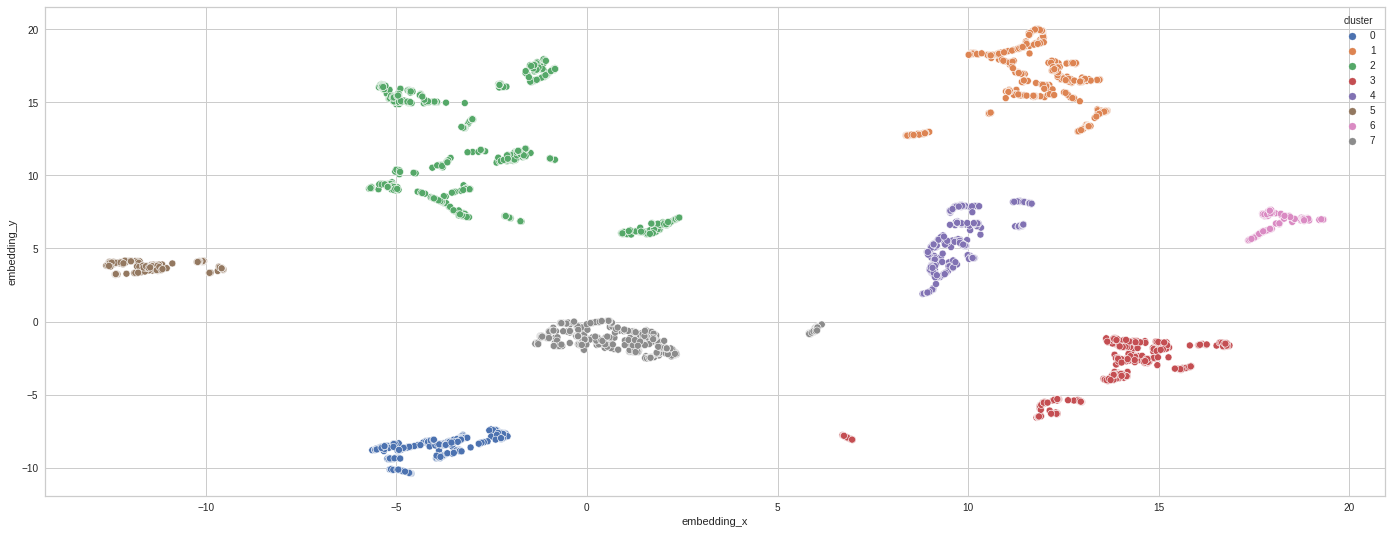

In [119]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

### **9.4 Cluster Profile**

In [128]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,1
1,13047,3232.59,56.0,171.0,0.028302,35.0,6
2,12583,6705.38,2.0,232.0,0.040323,50.0,1
3,13748,948.25,95.0,28.0,0.017921,0.0,5
4,15100,876.00,333.0,3.0,0.073171,22.0,2


In [130]:
# number of customers
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customers'] = 100 * (df_cluster['customer_id']/df_cluster['customer_id'].sum())

# gross revenue
df_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gross_revenue, how='inner', on='cluster')

# recency days
df_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, how='inner', on='cluster')

# # quantidade invoices
# df_qtde_invoice = df92[['qtde_invoices', 'cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster, df_qtde_invoice, how='inner', on='cluster')

# # quantidade itens
# df_qtde_items = df92[['qtde_items', 'cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster, df_qtde_items, how='inner', on='cluster')

# quantidade produtos
df_qtde_products = df92[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qtde_products, how='inner', on='cluster')

# # Average Ticket
# df_avg_ticket = df92[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')

# # Average Recency Days
# df_avg_recency_days = df92[['avg_recency_days', 'cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Number of returns
df_returns = df92[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_returns, how='inner', on='cluster')

# frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# # avg_basket_size
# df_avg_basket_size = df92[['avg_basket_size', 'cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster, df_avg_basket_size, how='inner', on='cluster')

# # avg_unique_basket_size
# df_avg_unique_basket_size = df92[['avg_unique_basket_size', 'cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster, df_avg_unique_basket_size, how='inner', on='cluster')

df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customers,gross_revenue,recency_days,qtde_products,qtde_returns,frequency
1,1,469,15.796564,9176.512431,21.392324,423.236674,321.650320,0.094390
6,6,145,4.883799,3164.253379,34.427586,173.875862,23.482759,0.060415
3,3,433,14.584035,2653.024758,51.637413,98.588915,14.808314,0.049977
4,4,355,11.956888,2419.750366,44.219718,128.146479,21.580282,0.042380
7,7,415,13.977770,1203.160048,60.522892,53.226506,7.703614,0.042165
0,0,278,9.363422,954.737698,77.489209,36.514388,5.723022,0.081885
5,5,162,5.456383,819.306358,85.728395,27.944444,4.000000,0.124034
2,2,712,23.981138,695.095309,108.484551,22.064607,15.134831,0.263756


In [126]:
#1 Cluster Insiders  
#6 Cluster More Products
#3 Cluster Spend Money
#4 Cluster Even More Products
#7 Cluster Less Days
#0 Cluster Less 1k
#5 Cluster Stop Returns
#2 Cluster More Buy

## **10.0 EDA dos Clusters**

### **10.1 Mind Map de Hipóteses**

1. Fenômeno
2. Entidades (Customer, Location, Finance, Family)
3. Características da Entidade (Customer, Idade, Salário, Escolaridade)

### **10.2 Hipóteses de Negócio**

1. Afirmação
2. Comparação de variáveis
3. Valor base de comparação

In [131]:
df10 = df92.copy()

In [132]:
df10.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,1
1,13047,3232.59,56.0,171.0,0.028302,35.0,6
2,12583,6705.38,2.0,232.0,0.040323,50.0,1
3,13748,948.25,95.0,28.0,0.017921,0.0,5
4,15100,876.00,333.0,3.0,0.073171,22.0,2


#### Hipótese de compra:

Afirmação | cluster | chute

1. 80% dos clientes utilizam cartão como forma de pagamento.
2. Os clientes do cluster insiders possuim um ticket médio 10% maiir que do cluste More Products.
3. Os clientes do cluster Insiders possuem um basket size acima de 5 produtos.
4. **Os clientes do cluster Insiders possuem um volume (produtos) de compra correspondente acima de 10% do percentual total de compras.**
5. **Os clientes do cluster Insiders possuem um volume (faturamento) de compra correspondente acima de 10% do percentual total de compras.**
6. **Os clientes do cluster Insiders possuem um numero de devoluções abaixo da média da base total de clientes.**
7. **A mediana do faturamento do cluster Insiders é 10% maior do que a mediana do faturamento geral**
8.

##### **H1. Os clientes do cluster Insiders possuem um volume (produtos) de compras acima de 10% do percentual total de compras.**
Verdadeiro. Os clientes Insiders possuem o volume de compra de 54.48% do total

In [144]:
df_vol_products_insiders = df10.loc[df10['cluster'] == 1, 'qtde_products'].sum()
df_vol_products_total = df10.loc[:,'qtde_products'].sum()

print('Volume de Produtos Insiders: {:.2f}%'.format(100 * df_vol_products_insiders/df_vol_products_total))

Volume de Produtos Insiders: 54.48%


##### **H2. Os clientes do cluster Insiders possuem um volume (faturamento) de compra correspondente acima de 10% do percentual total de compras.**
Verdadeiro. Os clientes Insiders representam 52.72% do faturamento.

In [143]:
df_gmv_products_insiders = df10.loc[df10['cluster'] == 1, 'gross_revenue'].sum()
df_gmv_products_total = df10.loc[:,'gross_revenue'].sum()

print('GMV Insiders: {:.2f}%'.format(100 * df_gmv_products_insiders/df_gmv_products_total))

GMV Insiders: 52.72%


##### **H3. Os clientes do cluster Insiders possuem um numero de devoluções abaixo da média da base total de clientes.**
Falso. O cluster Insiders tem média de devoluções acima da média geral.

In [146]:
df_avg_return_insiders = df10.loc[df10['cluster'] == 1, 'qtde_returns'].mean()
df_avg_return_total = df10.loc[:, 'qtde_returns'].mean()

print('Avg Return Insiders: {:.2f} - Avg Return Total: {:.2f}'.format(df_avg_return_insiders, df_avg_return_total))

Avg Return Insiders: 321.65 - Avg Return Total: 62.16


##### **H4. A mediana do faturamento do cluster Insiders é 10% maior do que a mediana do faturamento geral**
Verdadeiro.

In [166]:
df_median_gmv_insiders = df10.loc[df10['cluster'] == 1, 'gross_revenue'].median()
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = (df_median_gmv_insiders - df_median_gmv_total) / df_median_gmv_total
print('Median Diff: {}%'.format(100 * gmv_diff))

Median Diff: 276.37360615316675%


#### Hipótese de cliente:

1. 60% dos clientes do cluster Insiders são do estado civil solteiro.  
2. 10% dos clientes do cluster Insiders estão na faixa de 24-35 anos.
3. 40% das localidades de entrega dos clientes do cluster Insiders estão dentro de um raio de 50km.
4. 5% dos clientes do cluster Insiders recebem mais de 100 mil dólares anualmente.
5. 90% dos clientes do cluster Insiders tem ensino superior completo.

#### Hipótese de produto:

1. 30% dos produtos em pacotes grandes são comprados por clientes do cluster Insiders.
2. A mediana dos preços dos produtos comprados pelos clientes do cluster Insiders é 10% maior que a mediana de todos os preços dos produtos.
3. O percentil de preço dos produtos comprados pelos clientes do cluster Insiders.
4. O peso médio dos produtos comprados pelos clientes do cluster insiders é maior que o peso médio comprado pelos outros clusters.
5. A idade média dos produtos comprados pelos clientes do cluster insiders é menor do que 15 dias.

#### Perguntas de negócio:

1. Quem são as pessoas elegíveis ?

In [173]:
df_insiders = df10.loc[df10['cluster'] == 1,]
df_insiders.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,1
2,12583,6705.38,2.0,232.0,0.040323,50.0,1
6,14688,5630.87,7.0,327.0,0.057221,399.0,1
8,15311,60767.90,0.0,2379.0,0.243316,474.0,1
12,16029,72882.09,38.0,241.0,0.184524,8004.0,1


2. Quantos clientes farão parte do grupo?

In [175]:
df_insiders.shape[0]

469

3. Quais as características desses clientes?

In [178]:
df_cluster[df_cluster['cluster'] == 1]

,cluster,customer_id,perc_customers,gross_revenue,recency_days,qtde_products,qtde_returns,frequency
1,1,469,15.796564,9176.512431,21.392324,423.236674,321.65032,0.09439


In [182]:
import scipy.stats as st

data = df_insiders['gross_revenue']

#Bootstrap
intervalo_confianca = st.t.interval(alpha=0.95,
                                     df=len(data),
                                     loc=np.mean(data),
                                     scale=st.sem(data))

In [184]:
intervalo_confianca # Gross Renevue

(7157.412956277608, 11195.611905129645)

4. Qual a porcentagem de contribuição do faturamento, vindo do insiders?

In [185]:
df_gmv_products_insiders = df10.loc[df10['cluster'] == 1, 'gross_revenue'].sum()
df_gmv_products_total = df10.loc[:,'gross_revenue'].sum()

print('GMV Insiders: {:.2f}%'.format(100 * df_gmv_products_insiders/df_gmv_products_total))

GMV Insiders: 52.72%


5. Qual a expectativa de faturamento desse grupo para os proximos meses ?

6. Quais as condições para uma pessoa ser elegível?

In [186]:
# Estar no intervalo de confiança do Gross Revenue do Insiders

7. Quais as condições para uma pessoa ser removida?

In [187]:
# Estar fora do invervalo de confiança de Gross Revenue do Insiders

8. Qual a garantia que o programa Insiders é melhor que o resto da base?

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

### **10.3 Priorização das Hipóteses**

### **10.4 Validação das Hipóteses**

### **10.5 Quadro de Respostas**

## **11.0 Deploy to Production**